In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
weather_df = pd.read_csv("weather.csv")

In [3]:
weather_df

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog
...,...,...,...,...,...,...,...,...
8779,12/31/2012 19:00,0.1,-2.7,81,30,9.7,100.13,Snow
8780,12/31/2012 20:00,0.2,-2.4,83,24,9.7,100.03,Snow
8781,12/31/2012 21:00,-0.5,-1.5,93,28,4.8,99.95,Snow
8782,12/31/2012 22:00,-0.2,-1.8,89,28,9.7,99.91,Snow


As we can see above, the data consists of hourly weather data from 2012. Various attributes are recorded, such as temperature, dew point temperature, relative humidity, wind speed, visibility, atmospheric pressure, etc.

# Data Cleaning & Transformation

### Check for missing values:

In [32]:
weather_df.isnull().sum()

Date/Time           0
Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
Weather             0
dtype: int64

There are no missing values in the dataset, which means we can immediately move on.

### Convert "Date/Time" to datetime format and extract time features:

In [34]:
# Convert "Date/Time" column to datetime format
weather_df["Date/Time"] = pd.to_datetime(weather_df["Date/Time"])

In [35]:
# Extract month, day, and hour and create new columns for them
weather_df["Month"] = weather_df["Date/Time"].dt.month
weather_df["Day"] = weather_df["Date/Time"].dt.day
weather_df["Hour"] = weather_df["Date/Time"].dt.hour

In [39]:
weather_df.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather,Month,Day,Hour
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog,1,1,0
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog,1,1,1
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog",1,1,2
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog",1,1,3
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog,1,1,4


The **"Date/Time"** column has successfully been converted to datetime format, allowing us to easily extract the month, day, and hour from each row. 

This will be beneficial for further time-based analysis and visualisation.

### Identifying and handling outliers:

In [41]:
# Identify outliers using IQR (interquartile range) method for numeric columns
outliers_dict = {}
numeric_columns = weather_df.select_dtypes(include=["float64", "int64"]).columns

for col in numeric_columns:
    Q1 = weather_df[col].quantile(0.25)
    Q3 = weather_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = weather_df[(weather_df[col] < lower_bound) | (weather_df[col] > upper_bound)]
    outliers_dict[col] = len(outliers)

In [42]:
outliers_dict

{'Temp_C': 0,
 'Dew Point Temp_C': 0,
 'Rel Hum_%': 2,
 'Wind Speed_km/h': 162,
 'Visibility_km': 3539,
 'Press_kPa': 207,
 'Month': 0,
 'Day': 0,
 'Hour': 0}

Here, outliers for each numeric column were identified using the IQR method, which works as follows:
1. Calculate the IQR for each column
2. Defind upper and lower bounds for outliers:

    $\text{Lower bound} = Q1-1.5\times{\text{IQR}}$

    $\text{Upper bound} = Q3+1.5\times{\text{IQR}}$

3. Count the number of outliers for each column


The results show that columns **"Wind Speed_km/h"**, **"Visibility_km"**, and **"Press_kPa"** each had a significant number of outliers. From this alone, it is difficult to determine whether they are genuine outliers or just natural variance in the data.

The column **"Rel Hum_%"** only had 2 outliers, so it would be wise to remove or impute them.

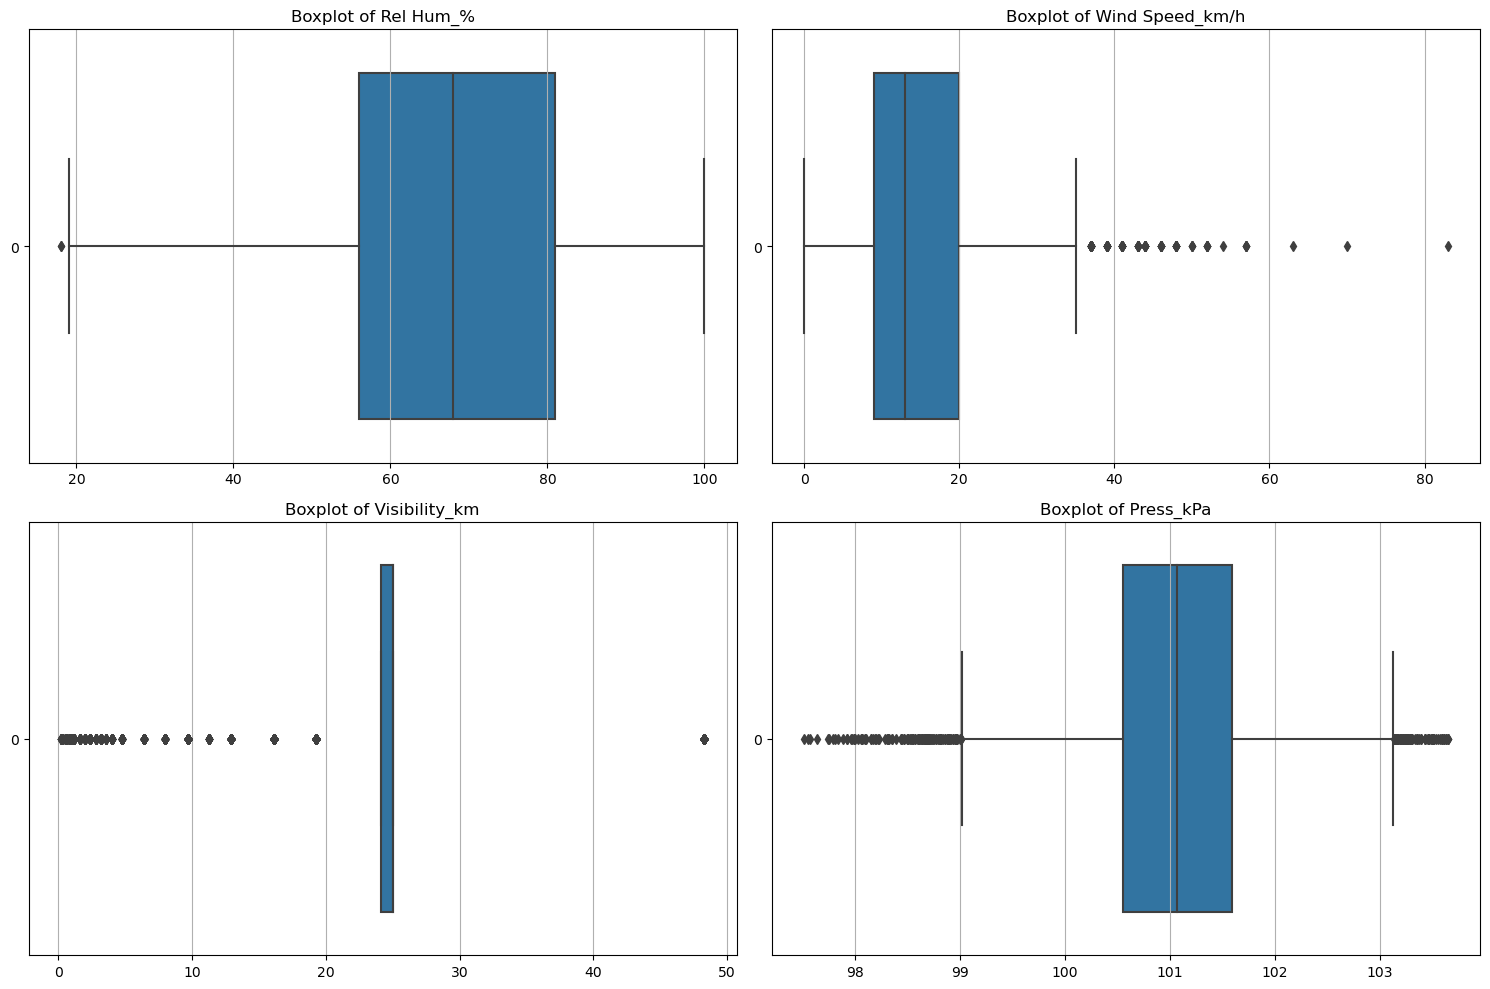

In [54]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(["Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(weather_df[col], orient="h")
    plt.title(f"Boxplot of {col}")
    plt.grid(axis="x")
    
plt.tight_layout()
plt.show()

##### Rel Hum_%:
There are a few low outliers, but they are close to the whiskers of the boxplot, suggesting that they might be silent variations rather than extreme outliers.

Given that the outliers are close to the whiskers, the values can be capped/floored to the whisker values.

##### Wind Speed_km/h:
The upper whisker extends beyond the interquartile range, indicating that there are some high wind speed values. These could be genuine outliers, but they could also represent occasional high wind speed events.

Considering high wind speeds could be genuine readings, it would make more sense to cap them to a predefined upper bound than impute them.

##### Visibility_km:
There is a significant concentration of data points at the higher visibility levels, with several low visibility readings falling outside the interquartile range. Given that this is weather data, low visibility conditions are not uncommon and could be a natural variance.

Considering this, it would be wise to leave these alone.

##### Press_kPa:
There are both low and high outliers. However, they are close to the whiskers, suggesting that they might be slight variations.

Similarly to **Rel_Hum_%**, these outliers are close to the whiskers, so the best course would be to cap them to the whisker values.

In [55]:
def cap_floor_values(data, col):
    """Cap/floor based on IQR whisker values"""
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data[col] = data[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    return data

# Cap outliers for the 3 columns
for col in ["Rel Hum_%", "Wind Speed_km/h", "Press_kPa"]:
    weather_df = cap_floor_values(weather_df, col)

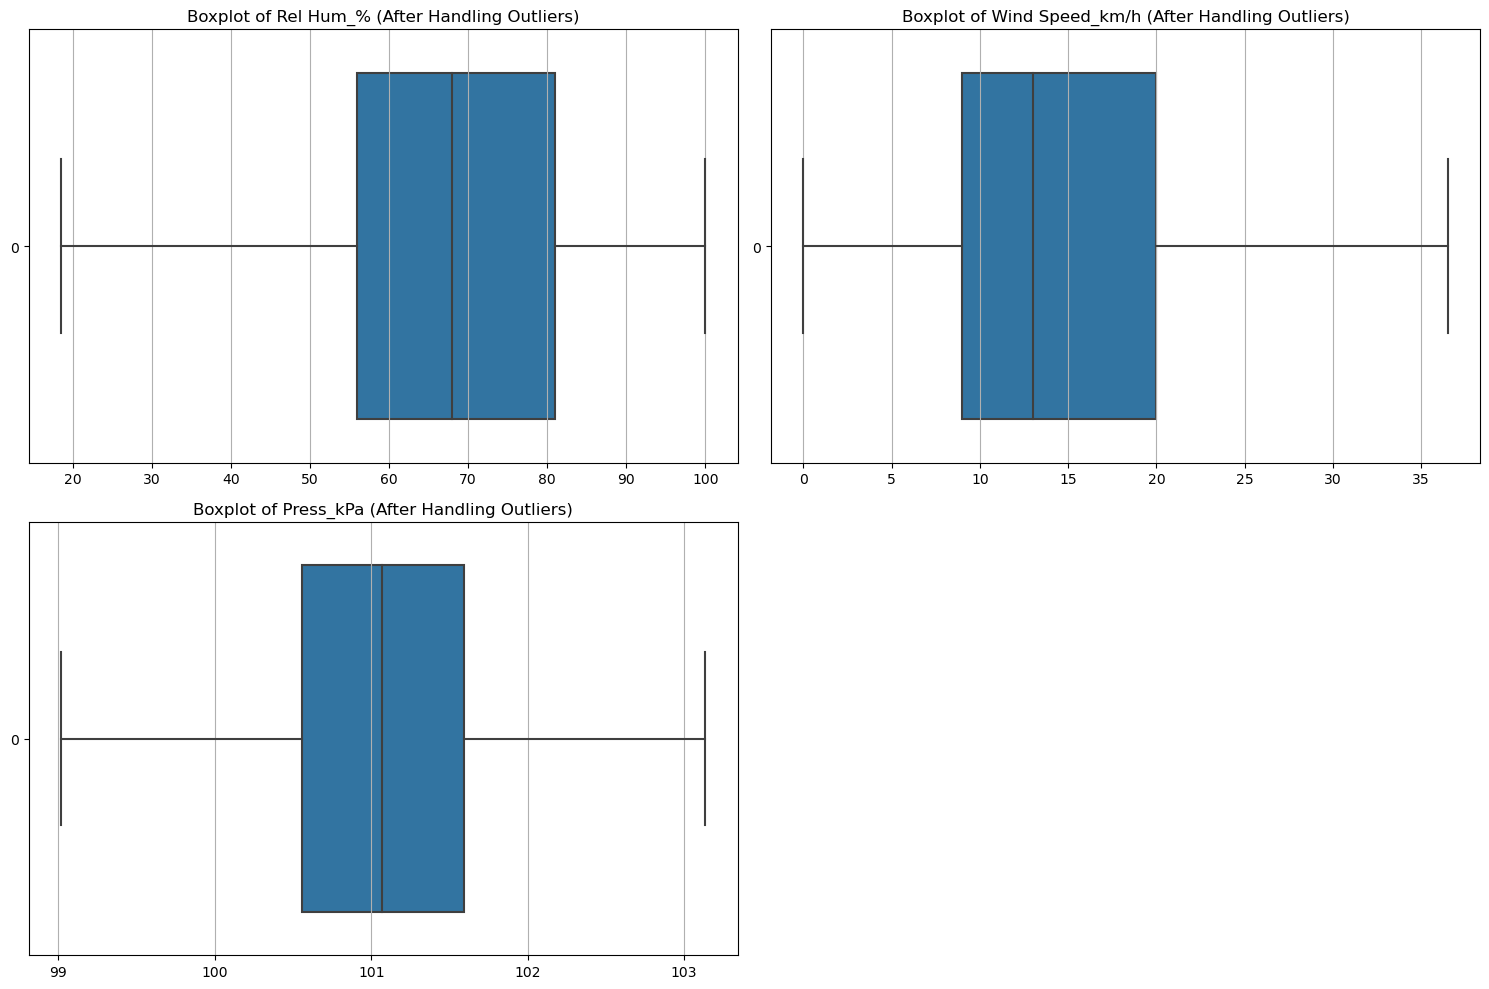

In [57]:
# Verify the changes using boxplots
plt.figure(figsize=(15, 10))

for i, col in enumerate(["Rel Hum_%", "Wind Speed_km/h", "Press_kPa"], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(weather_df[col], orient="h")
    plt.title(f"Boxplot of {col} (After Handling Outliers)")
    plt.grid(axis="x")
    
plt.tight_layout()
plt.show()

From these boxplots, we can see that the outliers have been capped to the whisker values. This brings them within the acceptable range based on the IQR method.

Outliers for **Visibility_km** were left alone as it was decided that they represent genuine low visibility events, such as fog or snow.

# Descriptive Analysis:

### Average, median, minimum, and maximum temperature for dataset:

In [70]:
weather_df.head(3)

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather,Month,Day,Hour
0,2012-01-01 00:00:00,-1.8,-3.9,86.0,4.0,8.0,101.24,Fog,1,1,0
1,2012-01-01 01:00:00,-1.8,-3.7,87.0,4.0,8.0,101.24,Fog,1,1,1
2,2012-01-01 02:00:00,-1.8,-3.4,89.0,7.0,4.0,101.26,"Freezing Drizzle,Fog",1,1,2


In [63]:
temp_stats = {
    "Average Temperature" : weather_df["Temp_C"].mean(),
    "Median Temperature" : weather_df["Temp_C"].median(),
    "Minimum Temperature" : weather_df["Temp_C"].min(),
    "Maximum Temperature" : weather_df["Temp_C"].max()
}

temp_stats

{'Average Temperature': 8.798144353369764,
 'Median Temperature': 9.3,
 'Minimum Temperature': -23.3,
 'Maximum Temperature': 33.0}

The average temperature for the dataset is around 8.8 degreees C, which is slightly below the median of 9.3C. This suggests a slightly left-skewed distribution, where there are some notably cold days pulling the average down.

The temperature range is broad, spanning from -23.3C to 33C. This wide range shows that this region experienced diverse weather conditions throughout the year.

### Month with highest average wind speed:

In [68]:
# Display average wind speed for each month in descending order
weather_df.groupby("Month")["Wind Speed_km/h"].mean().sort_values(ascending=False)

Month
1     17.742608
12    17.463038
4     17.083333
10    15.288978
2     14.830460
6     14.681250
3     14.245296
9     14.073611
11    13.937500
8     13.895161
5     12.846774
7     11.887097
Name: Wind Speed_km/h, dtype: float64

The results indicate that January (month 1) has the highest average wind speed, closely followed by December and April. This could be explained by the possibility of storms or other seasonal conditions typical for that region. January and December are winter months, so the weather is likely to be worse.

# Data Visualisation

### Temperature Histogram:

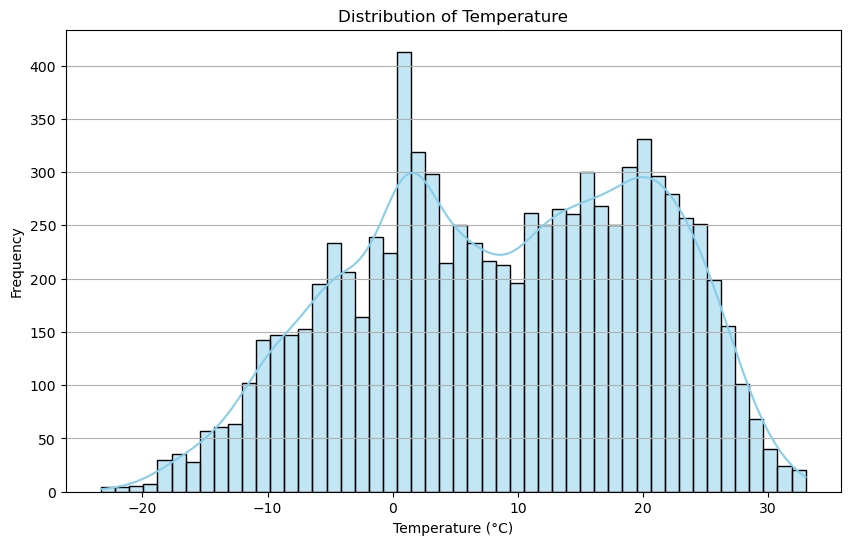

In [71]:
plt.figure(figsize=(10, 6))

sns.histplot(weather_df["Temp_C"], bins=50, color="skyblue", kde=True)

plt.title("Distribution of Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.grid(axis="y")

plt.show()

This histogram allows us to look at the distribution of temperatures across the year.

The temperature data seems to have a bimodal distribution, with two peaks. This might suggest two primary seasons, perhaps representing summer and winter temperatures.

Most of the temperatures revolve around two clusters:
- Around -10°C to 0°C
- Around 15°C to 25°C

There is a broad range of temperatures, showing the diverse weather conditions throughout the year.

### Frequency of Different Weather Conditions:

In [72]:
# Extract and count the unique weather conditions
weather_conditions = weather_df["Weather"].str.split(",", expand=True).stack().value_counts()

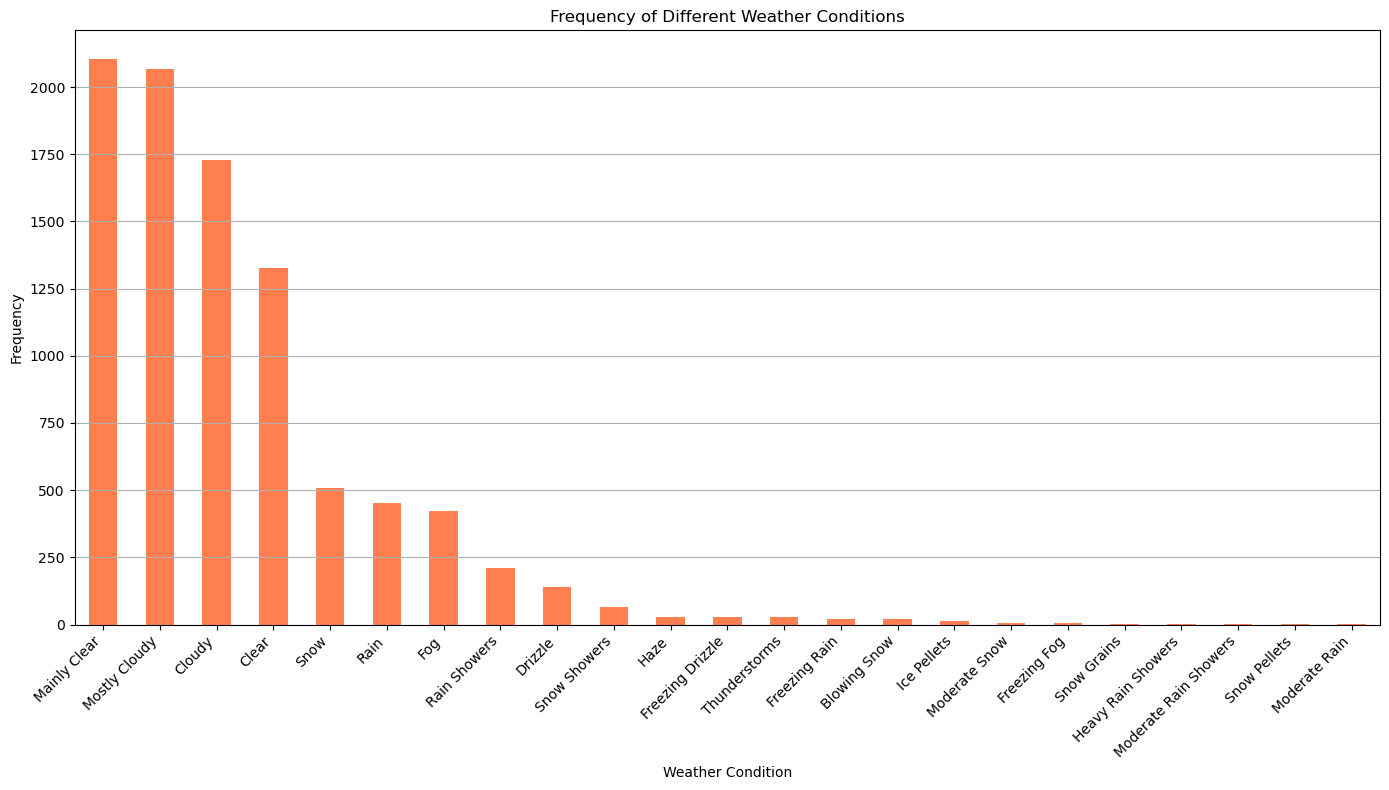

In [73]:
# Create bar chart
plt.figure(figsize=(14, 8))

weather_conditions.plot(kind="bar", color="coral")

plt.title("Frequency of Different Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

The most frequent weather conditions are variants of clear and cloudy. This suggests that for majority of the year there is clear weather without disruptions.

Weather conditions such as rain, snow, and fog also appear fairly frequently, showing diversity in the yearly weather, although they are not as frequent as clear and cloudy conditions.

Rainy conditions, such as rain showers and drizzle, are not very frequent. More extreme rainy conditions, such as thunderstorms and heavy/moderate rain showers are even less frequent with very few occurrences.

It is also worth noting that cold conditions, such as snow and freezing rain, are very infrequent too. This suggests that the location is somewhere that is mildy warm for most of the year.

### Correlation Heatmap:

In [77]:
# Calculate correlation matrix
correlation_matrix = weather_df.corr(numeric_only=True)

correlation_matrix

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Month,Day,Hour
Temp_C,1.000000,0.932714,-0.220181,-0.059849,0.273455,-0.247350,2.180482e-01,9.299991e-03,1.068878e-01
Dew Point Temp_C,0.932714,1.000000,0.139491,-0.096415,0.050813,-0.331250,2.996407e-01,6.390196e-03,1.720132e-02
Rel Hum_%,-0.220181,0.139491,1.000000,-0.100099,-0.633685,-0.228739,2.320398e-01,-1.056923e-02,-2.435015e-01
Wind Speed_km/h,-0.059849,-0.096415,-0.100099,1.000000,0.008969,-0.345258,-2.624840e-02,6.612771e-02,8.199727e-02
Visibility_km,0.273455,0.050813,-0.633685,0.008969,1.000000,0.227832,-2.731366e-02,3.365052e-02,6.438479e-02
Press_kPa,-0.247350,-0.331250,-0.228739,-0.345258,0.227832,1.000000,6.788912e-02,1.177330e-03,-3.137779e-02
Month,0.218048,0.299641,0.232040,-0.026248,-0.027314,0.067889,1.000000e+00,6.443300e-03,2.574200e-15
Day,0.009300,0.006390,-0.010569,0.066128,0.033651,0.001177,6.443300e-03,1.000000e+00,1.429094e-16
Hour,0.106888,0.017201,-0.243501,0.081997,0.064385,-0.031378,2.574200e-15,1.429094e-16,1.000000e+00


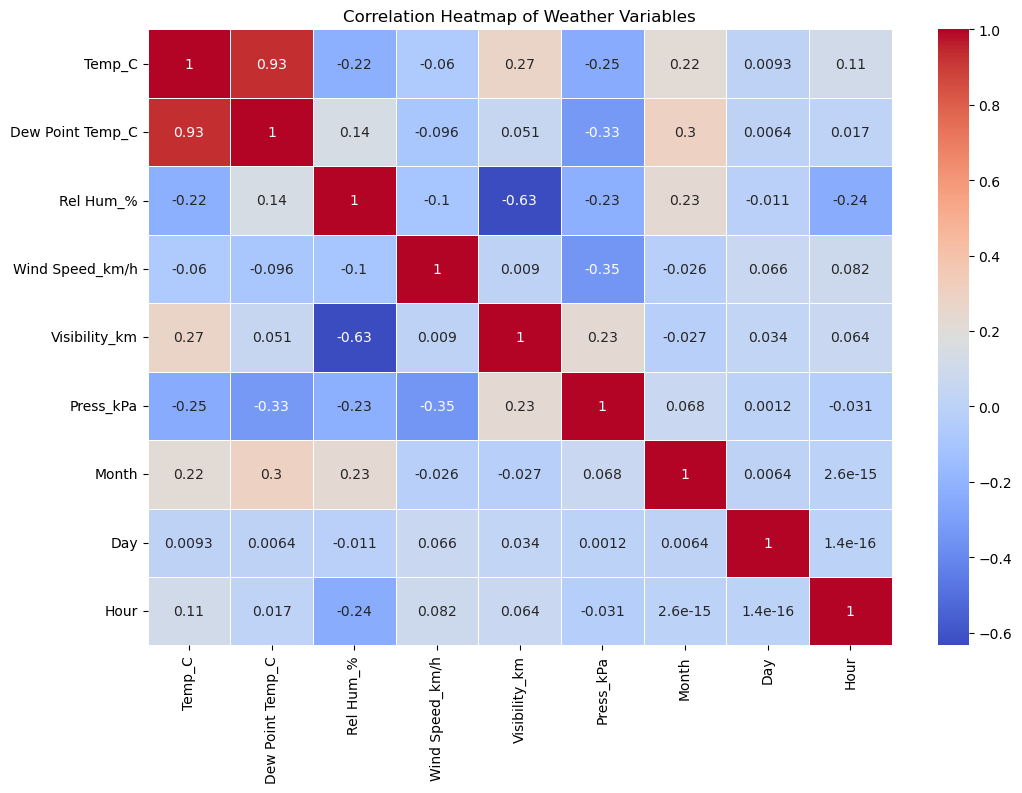

In [78]:
# Plot heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidth=0.5, linecolor="white")
plt.title("Correlation Heatmap of Weather Variables")

plt.show()

There is a strong positive correlation between temperature and dew point temperature. This is expected as the dew point often rises with the temperature, given constant pressure and humidity conditions.

There is a slight positive correlation between temperature and visibility, suggesting that as temperature increases, visibility tends to improve. This could be down to conditions like fog, which typically occur and lower temperatures and reduces visibility.

There is a negative correlation between relative humidity and visibility, indicating that as humidity increases, visibility decreases. This can also be related to conditions like fog or mist that reduce visibility and are associated with higher humidity levels.

There is a slight negative correlation between pressure and visibility. While the relationship is not direct, other factors might be at play.

There is a slight negative correlation between wind speed and visibility, suggesting that higher wind speeds might be associated with reduced visibility. This could potentially be due to conditions like snowstorms.

# Time Series Analysis:

### Daily average temperature over the year:

In [81]:
# Calculate daily average temperature
daily_avg_temp = weather_df.groupby(weather_df["Date/Time"].dt.date)["Temp_C"].mean()

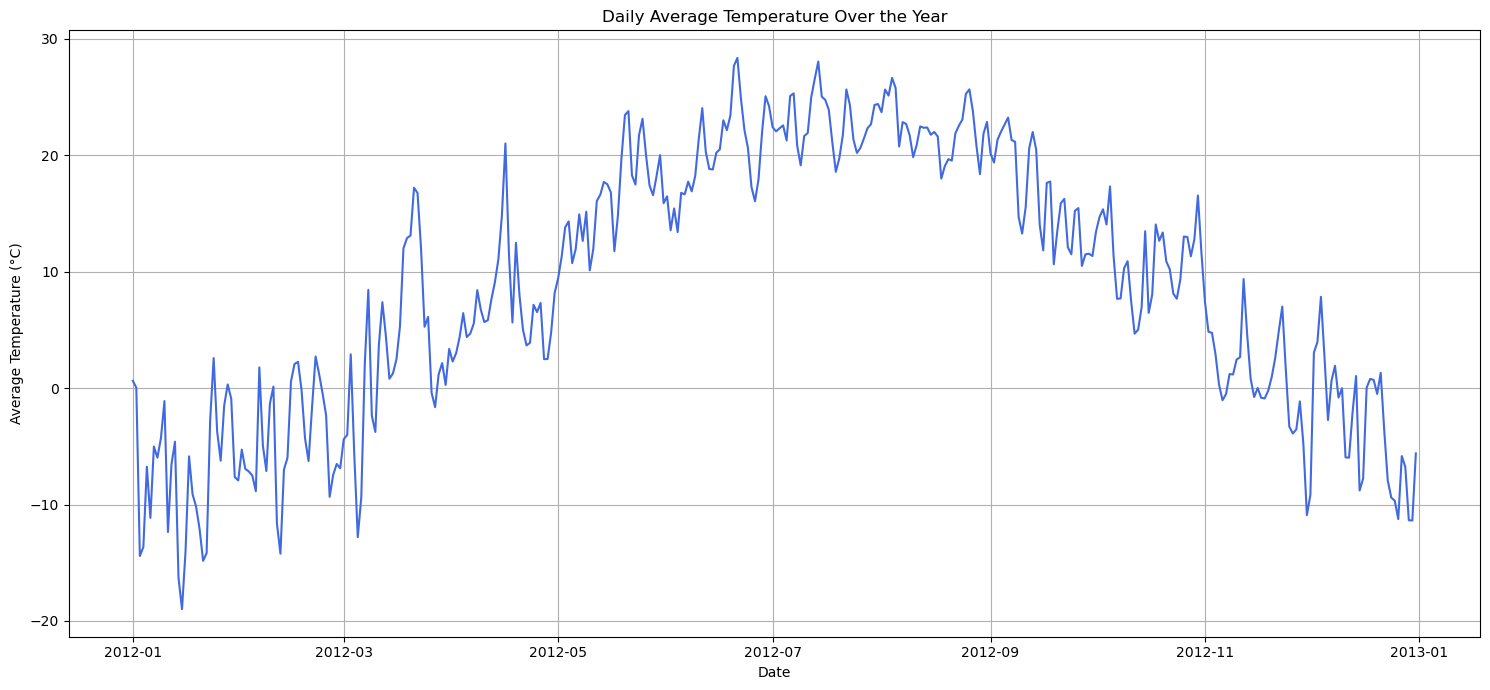

In [82]:
plt.figure(figsize=(15, 7))

daily_avg_temp.plot(color="royalblue")

plt.title("Daily Average Temperature Over the Year")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.grid(True)

plt.tight_layout()
plt.show()

A clear cyclic pattern is evident, showing the seasonal variations in temperature. The temperature rises and falls, indicating the transition from winter to summer and back to winter.

The highest temperatures (summer months) appear around the middle of the year, while the lower temperatures (winter months) are at the beginning and end of the year.

### Atmospheric pressure trends:

In [83]:
# Plot the trend in atmospheric pressure
daily_avg_pressure = weather_df.groupby(weather_df["Date/Time"].dt.date)["Press_kPa"].mean()

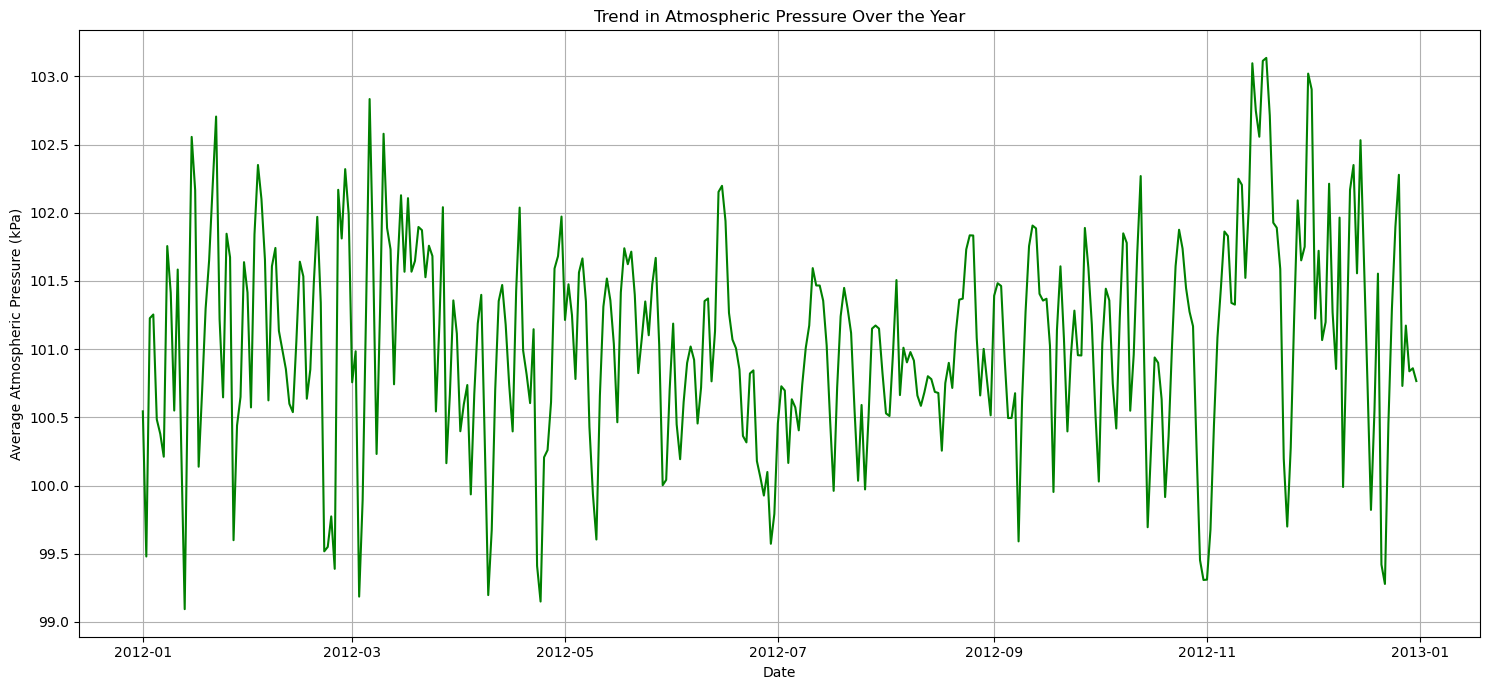

In [84]:
plt.figure(figsize=(15, 7))

daily_avg_pressure.plot(color="green")

plt.title("Trend in Atmospheric Pressure Over the Year")
plt.xlabel("Date")
plt.ylabel("Average Atmospheric Pressure (kPa)")
plt.grid(True)

plt.tight_layout()
plt.show()

Unlike the temperature, atmospheric pressure does not exhibit a distinct cyclic pattern.

There are fluctuations in the pressure values, but these variations are relatively minor, and there is no clear seasonality evident in the pressure data.

The pressure seems to have some periodic short-term fluctuations but remains mostly stable over the year, which is typical since large-scale pressure changes are not as season-dependent as temperature.

# Statistical Analysis:

### ANOVA for monthly average temperature:

Null hypothesis:
- The monthly average temperatures are the same.

Alternative hypothesis:
- At least one month's average temperature is different.

In [89]:
# Group data by month and extract temperature for ANOVA
grouped_temp = [weather_df["Temp_C"][weather_df["Month"] == month] for month in range(1, 13)]

In [92]:
# One-way ANOVA
f_stat, p_value = stats.f_oneway(*grouped_temp)

print(f"F-statistic: {f_stat}\np-value: {p_value}")

F-statistic: 3078.890460008758
p-value: 0.0


Given the extremely low p-value, we can reject the null hypothesis. This indicates that there is a statistically significant difference in the average temperatures between months.

### Correlation between wind speed and visibility:

In [93]:
# Calculate Pearson's correlation coefficient between wind speed and visibility
correlation_coefficient, correlation_p_value = stats.pearsonr(weather_df["Wind Speed_km/h"], weather_df["Visibility_km"])

print(f"Pearson's correlation coefficient: {correlation_coefficient}\np-value: {correlation_p_value}")

Pearson's correlation coefficient: 0.008968562798706961
p-value: 0.40065172263960513


The results show a very weak correlation, suggesting a negligible linear relationship between wind speed and visibility.

The p-value is not statistically significant which indicates that the observed correlations are not reliable.

# Advanced Analysis:

### Clustering hours of the day based on weather conditions

This can be achieved using k-means clustering. Features will include temperature, dew point, relative humidity, wind speed, visibility, and atmospheric pressure. The features need to be scaled and then the k-means algorithm will be applied.

In [94]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [95]:
# Select features for clustering
features = ["Temp_C", "Dew Point Temp_C", "Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"]

#Groupby hour to get average conditions for each hour
hourly_data = weather_df.groupby("Hour").mean().reset_index()

hourly_conditions = hourly_data[features]

D:\Temp Files\ipykernel_4044\2566679774.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hourly_data = weather_df.groupby("Hour").mean().reset_index()


In [96]:
# Standardise data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(hourly_conditions)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
hourly_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Resulting clusters
hourly_data[["Hour", "Cluster"]]

D:\Programs\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Programs\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Hour,Cluster
0,0,2
1,1,2
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,3
9,9,3


Results:
- Cluster 0: Early morning hours (2AM to 7AM)
- Cluster 1: Afternoon to early evening hours (12PM to 6PM)
- Cluster 2: Late evening to early morning hours (8PM to 1AM and then 11PM to 1AM)
- Cluster 3: Late morning hours (8AM to 11AM)

The clustering suggests typical weather patterns across different times of the day. For instance, the early morning hours (cluster 0) might be cooler with different atmospheric conditions compared to the afternoon hours (cluster 1).

### Time series forecasting to predict future temperatures:

For this, the best option is to use the ARIMA model, which will be trained on a portion of the dataset and will be used to predict future temps.

In [97]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

In [98]:
# Split daily average temp data into training and testing sets (last 30 days as testing)
train = daily_avg_temp[:-30]
test = daily_avg_temp[-30:]

In [100]:
# Fit the ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

D:\Programs\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Programs\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Programs\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [108]:
# Forecast the next 30 days
forecast_result = model_fit.get_forecast(steps=30)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

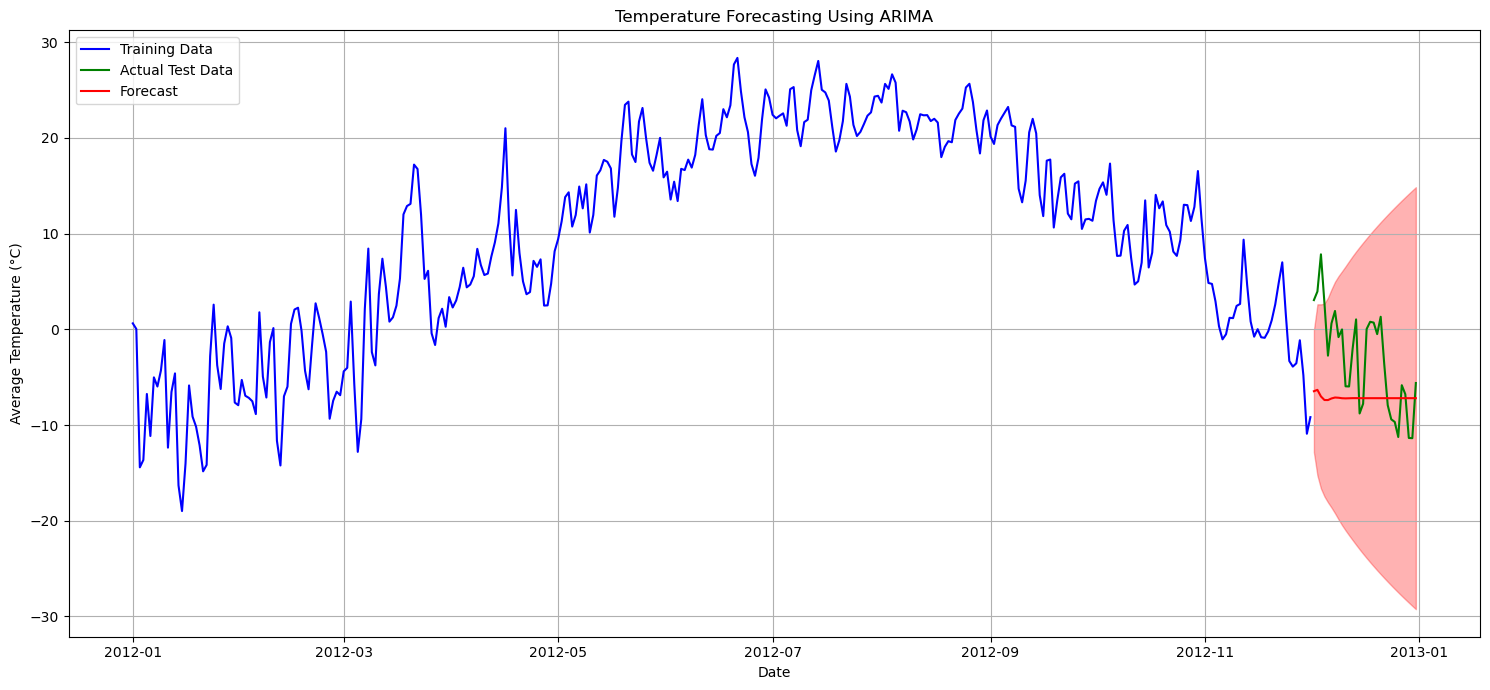

In [109]:
# Plot results
plt.figure(figsize=(15, 7))

plt.plot(train.index, train, label="Training Data", color="blue")
plt.plot(test.index, test, label="Actual Test Data", color="green")
plt.plot(pd.date_range(start=test.index[0], periods=30, freq="D"), forecast_mean, label="Forecast", color="red")

plt.fill_between(pd.date_range(start=test.index[0], periods=30, freq="D"), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="r", alpha=0.3)

plt.legend(loc="upper left")
plt.title("Temperature Forecasting Using ARIMA")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.grid(True)

plt.tight_layout()
plt.show()

- The blue line represents the training data.
- The green line represents the actual test data for the last 30 days.
- The red line depicts the forecasted temperatures for those 30 days.
- The shaded region around the red line shows the confidence interval for the forecast, indicating the range within which the actual values are expected to lie with a certain level of confidence.

Observations:

The forecasted temperature (red line) generally follows the trend of the actual data, capturing the rise and fall in temperature. However, there are discrepancies between the forecasted and actual values.

The confidence intervals widen as the forecast goes further into the future, which is typical since predicting further out generally carries more uncertainty.